In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from math import sqrt
import seaborn as sns; sns.set()
import ast


In [2]:
# ========== Title SENTIMENT vs Summary SENTIMENT  =================
#
# EXPERIMENT WITH TIMESTEP 1H
#
#

newsTitle =  pd.read_csv('/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentTitleAggregatedHourly/AAPL.csv')
newsSummary =  pd.read_csv('/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/AAPL.csv')

price = pd.read_csv('/home/simone/Desktop/NLFF/indexes/indexesAAPL.csv')


price = price.rename(index=str, columns={"date": "DATE"})
newsTitle = newsTitle.rename(index=str, columns={"initTime": "DATE"})
newsSummary = newsSummary.rename(index=str, columns={"initTime": "DATE"})
newsTitle = newsTitle.drop(['Unnamed: 0'], axis=1)
newsSummary = newsSummary.drop(['Unnamed: 0'], axis=1)


newsTitle['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in newsTitle['DATE']]
newsSummary['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in newsSummary['DATE']]


# This datased is already GMT+0
price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
#newsTitle['entSentVec'] = [ast.literal_eval(row) for row in newsTitle['entSentVec']]

#ALLIGNMENT Title SENTIMENT
initDate = max(newsTitle['DATE'][0], datetime(2017, 5, 22, 0, 0, 0))
finalDate = min(newsTitle['DATE'][len(newsTitle)-1],datetime(2018, 6, 21, 0, 0, 0))
newsTitle.drop(newsTitle[newsTitle.DATE > finalDate].index, inplace=True)
newsTitle.drop(newsTitle[newsTitle.DATE < initDate].index, inplace=True)
newsTitle = newsTitle.reset_index(drop=True)
price.drop(price[price.DATE > finalDate].index, inplace=True)
price.drop(price[price.DATE < initDate].index, inplace=True)
price = price.reset_index(drop=True)

for data in newsTitle['DATE']:
    if data not in price['DATE'].tolist():
        print(data)

assert len(price) == len(newsTitle)

#ALLIGNMENT Summary SENTIMENT
newsSummary.drop(newsSummary[newsSummary.DATE > finalDate].index, inplace=True)
newsSummary.drop(newsSummary[newsSummary.DATE < initDate].index, inplace=True)
newsSummary = newsSummary.reset_index(drop=True)

for data in newsSummary['DATE']:
    if data not in price['DATE'].tolist():
        print(data)

assert len(price) == len(newsSummary)


# FEATURES Title
cols_Title = list(newsTitle.columns)
cols_Title.remove('DATE')
sentiment = newsTitle[cols_Title]
X_Title = sentiment
for window in [5,10,15,20,30,50]:
    temp = sentiment.rolling(window).mean()
    temp.columns = temp.columns +'_'+str(window)
    X_Title = pd.concat([X_Title, temp],axis=1)
    
    
# FEATURES Summary
sentiment = newsSummary.drop(['DATE'], axis=1)
X_Summary = sentiment
for window in [5,10,15,20,30,50]:
    temp = sentiment.rolling(window).mean()
    temp.columns = temp.columns +'_'+str(window)
    X_Summary = pd.concat([X_Summary, temp],axis=1)
    




#NORMALIZATION:
min_max_scaler = preprocessing.MinMaxScaler()
X_Title = np.nan_to_num(np.asarray(X_Title, dtype=float))
X_Title = np.asarray(min_max_scaler.fit_transform(X_Title))

X_Summary = np.nan_to_num(np.asarray(X_Summary, dtype=float))
X_Summary = np.asarray(min_max_scaler.fit_transform(X_Summary))




TREND_WINDOWs = [(-48,0),(-35,0),(-28,0),(-7,0),(-1,0),(1,2),(1,8),(1,29),(1,36),(1,50)]

In [ ]:
# # ========== simple SVM =================

# #NORMALIZATION:
# min_max_scaler = preprocessing.MinMaxScaler()
# X_google = np.nan_to_num(np.asarray(X_google, dtype=float))
# X_google = np.asarray(min_max_scaler.fit_transform(X_google))

# X_dict = np.nan_to_num(np.asarray(X_dict, dtype=float))
# X_dict = np.asarray(min_max_scaler.fit_transform(X_dict))




# for (init, finish) in TREND_WINDOWs:
#     x_google = list()
#     x_dict = list()
#     #CONSTRUCT LABELS
#     y = list()
#     up = 0
#     down = 0

#     means = list()
#     runningMean = 0
#     for i in range(len(price['volume'])):
#         runningMean +=price['volume'][i]
#         means.append(runningMean/(i+1))

#     for i in range(abs(init),len(price)-finish):
#         s=np.sign(price['volume'][i+init:i+finish].mean() - means[i])
#         if(s==-1):
#             y.append(0)
#             down +=1
#         else:
#             y.append(1)
#             up +=1
#         x_google.append(X_google[i])
#         x_dict.append(X_dict[i])

#     y = np.array(y)
#     x_google = np.array(x_google)
#     x_dict = np.array(x_dict)



#     accs_google = []
#     accs_dict = []
#     MCC_google = []
#     MCC_dict = []
#     for c in np.logspace(-3,4,10):
#         for (x,y,MCCs,accs) in [(x_google,y,MCC_google,accs_google),(x_dict, y,MCC_dict,accs_dict)]:
#             print('.', end='')

#             #DATASET DIVISION:
#             train=0.7
#             nt=math.ceil(len(x)*train)
#             x_tv = x[:nt]
#             y_tv = y[:nt]
#             x_test = x[nt:]
#             y_test = y[nt:]

#             #print('UP: '+str(up)+'\t DOWN: '+str(down))
#             #print('UP TRAIN-VAL: '+str(sum(y_tv)/len(y_tv)*100)+'%')
#             #print('UP TEST: '+str(sum(y_test)/len(y_test)*100)+'%')

#             svm_model = svm.SVC(kernel='linear', C=c)
#             svm_model.fit(x_tv,y_tv)
#             y_pred = svm_model.predict(x_test)
#             acc = svm_model.score(x_test,y_test)
#             confmatrix = confusion_matrix(y_test, y_pred)
#             tn, fp, fn, tp = confmatrix.ravel()
#             denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
#             accs.append(acc)
#             MCCs.append(0 if denom== 0 else (tp*tn -fp*fn)/sqrt(denom) )
#     #       print('MCC,score',MCC)
#     #       print('Acc-score:',acc)
#     #       print('Window:',TREND_WINDOW)
#     #       print(confmatrix)
#     #       plt.plot(y_pred)
#     #       plt.plot(y_test)
#     #       plt.show()

#     plt.figure(figsize=(20,10))
#     plt.semilogx(np.logspace(-3,4,10), MCC_google,'--b', label='MCC_google')
#     plt.semilogx(np.logspace(-3,4,10), MCC_dict,'--r', label='MCC_dict')
#     plt.semilogx(np.logspace(-3,4,10),accs_google,'b', label='accs_google')
#     plt.semilogx(np.logspace(-3,4,10),accs_dict,'r', label='accs_dict' )

#     plt.xlabel('c')
#     plt.title('y(t) = 1(v(t'+'{0:+}'.format(init)+': t '+'{0:+}'.format(finish)+').mean() -  mean(v(0:t)))')

#     plt.legend()
#     #plt.savefig('volumePredictions/onlyNews/SVM/eccessiveVolumes_('+str(init)+','+str(finish)+').jpg')
#     plt.show()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

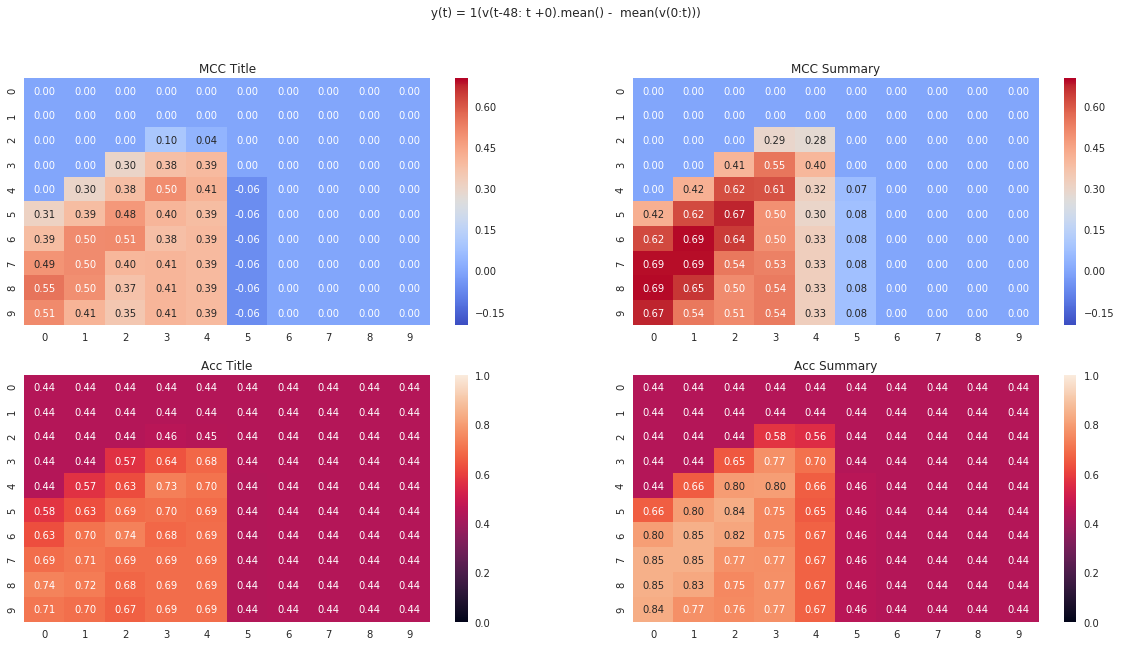

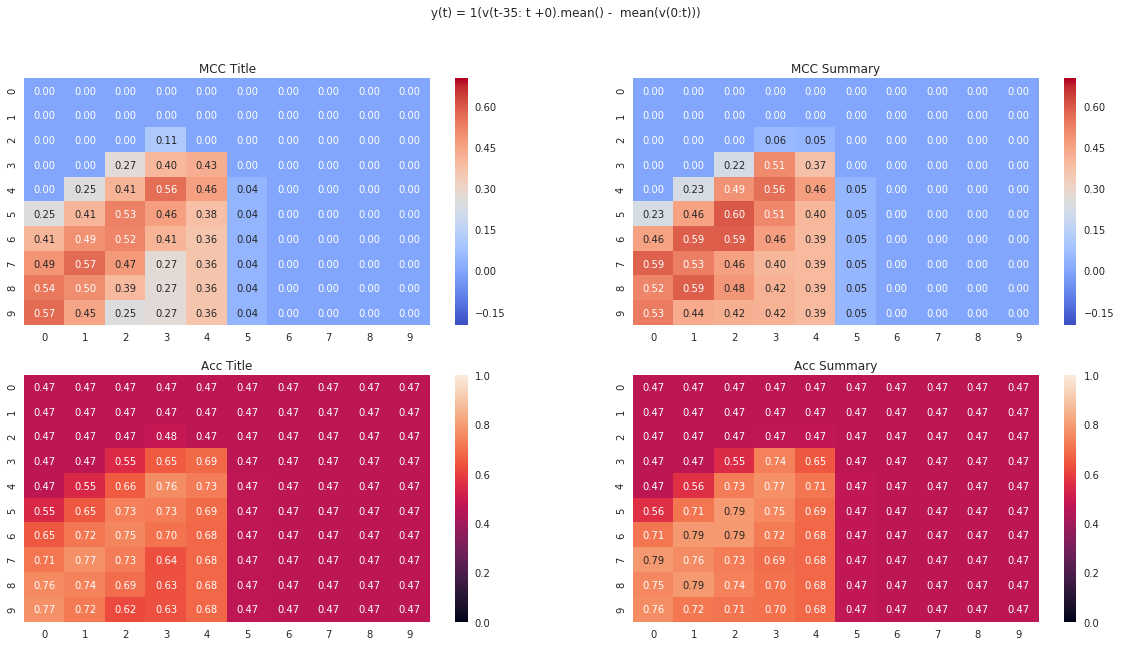

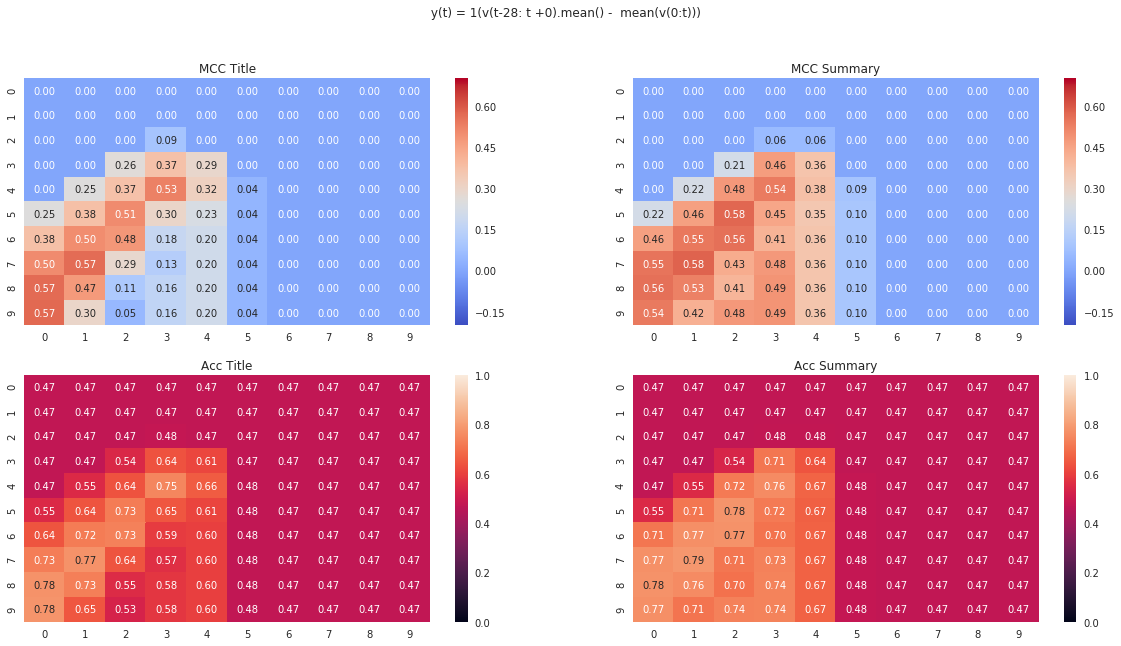

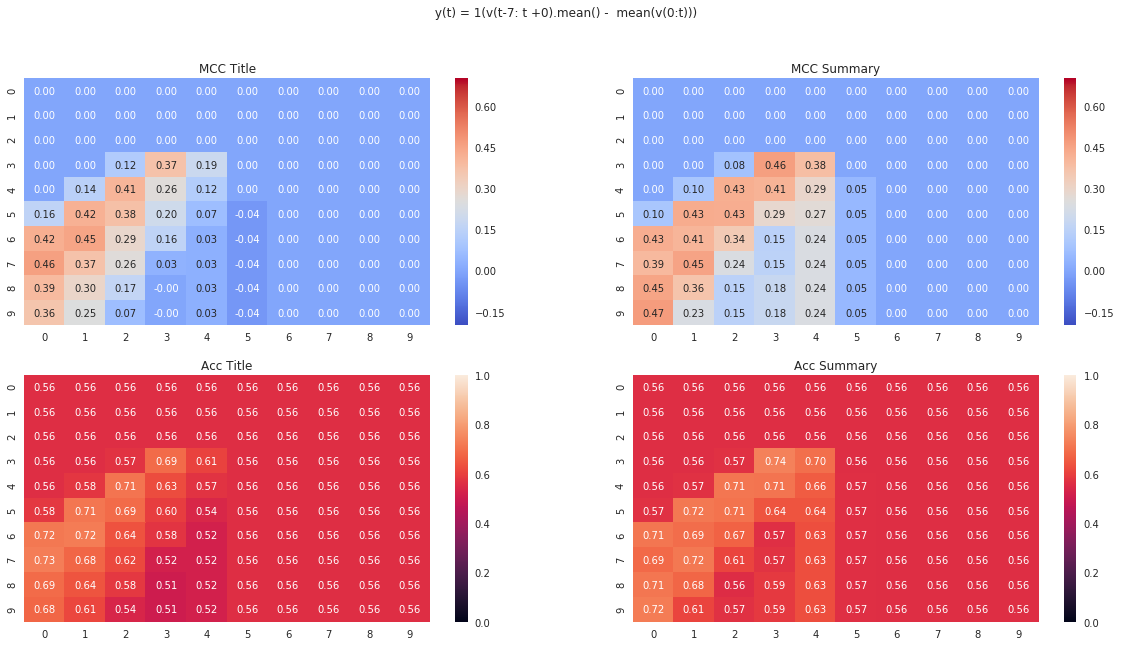

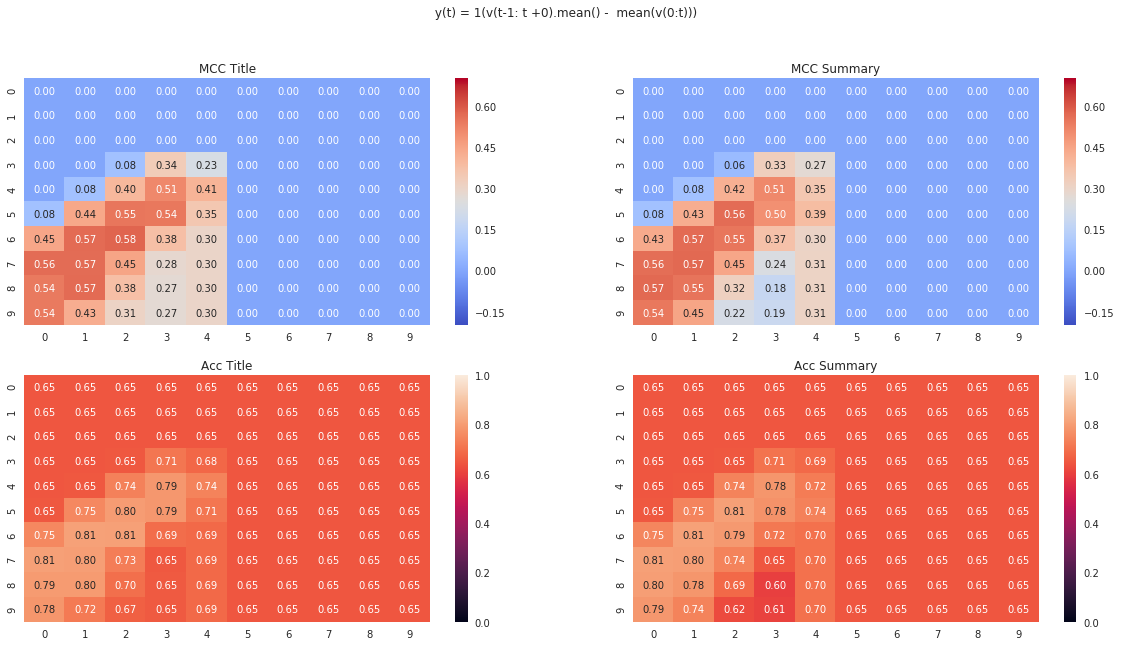

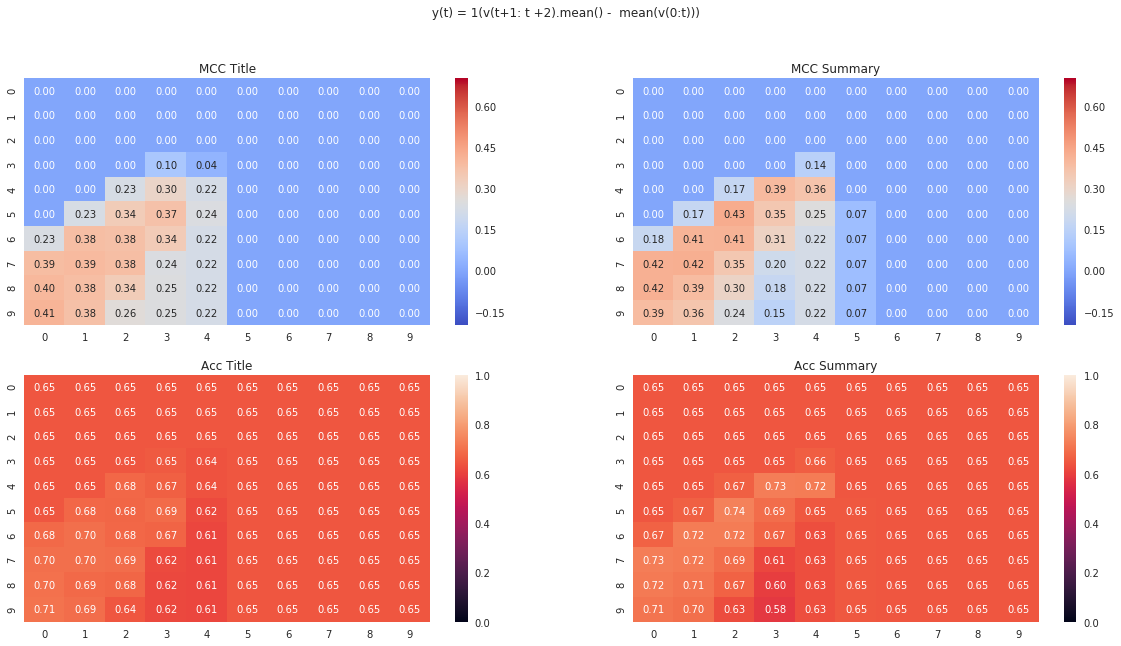

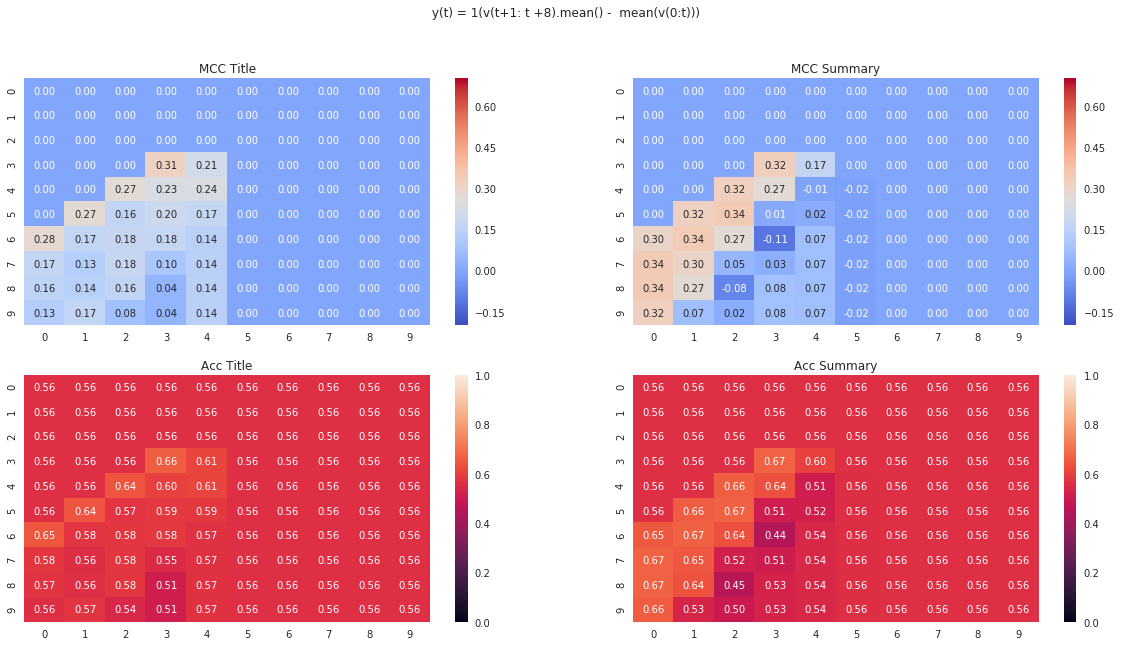

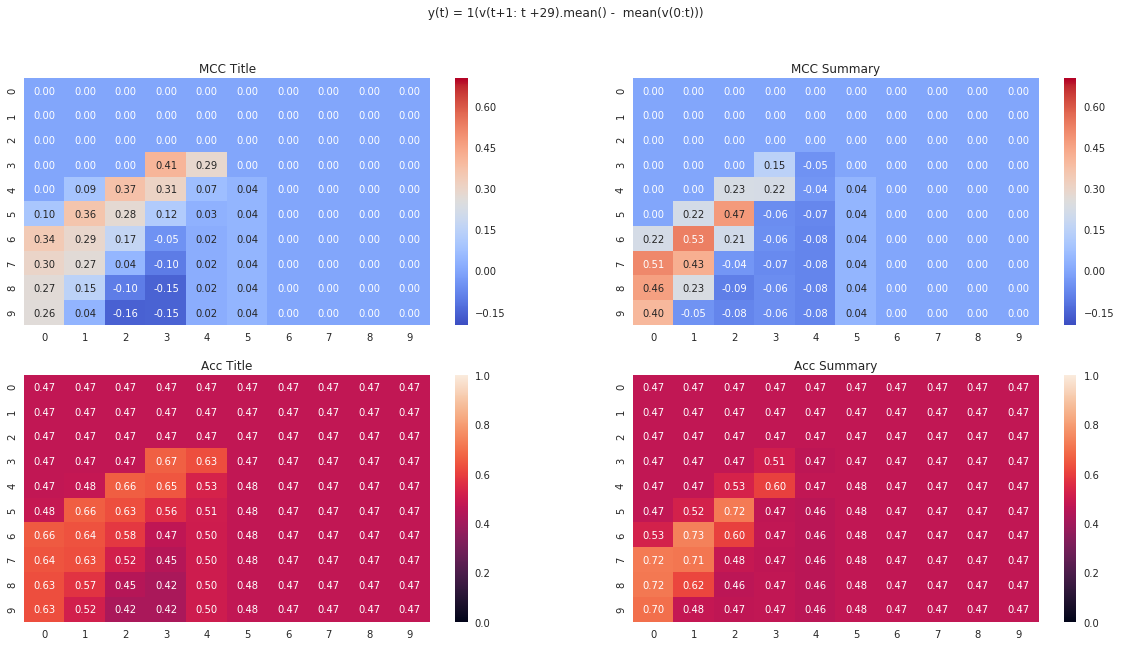

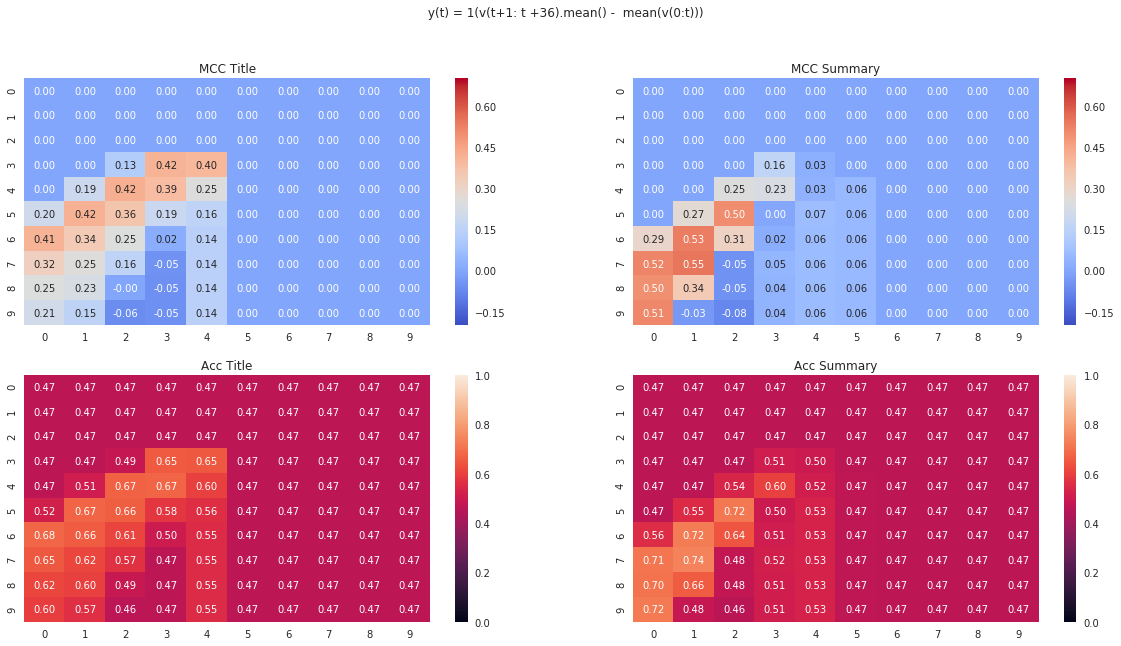

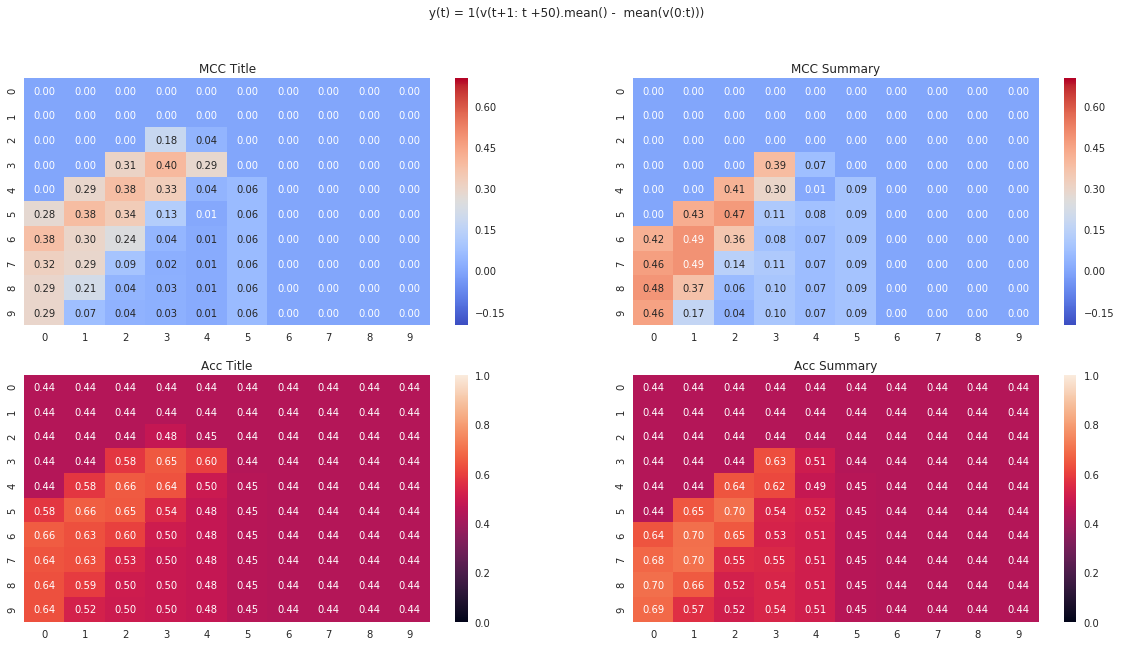

In [3]:
# ========== KSVM =================




for (init, finish) in TREND_WINDOWs:
    x_Title = list()
    x_Summary = list()
    #CONSTRUCT LABELS
    y = list()
    up = 0
    down = 0

    means = list()
    runningMean = 0
    for i in range(len(price['volume'])):
        runningMean +=price['volume'][i]
        means.append(runningMean/(i+1))

    for i in range(abs(init),len(price)-finish):
        s=np.sign(price['volume'][i+init:i+finish].mean() - means[i])
        if(s==-1):
            y.append(0)
            down +=1
        else:
            y.append(1)
            up +=1
        x_Title.append(X_Title[i])
        x_Summary.append(X_Summary[i])

    y = np.array(y)
    x_Title = np.array(x_Title)
    x_Summary = np.array(x_Summary)

    accs_Title = np.ones([10,10])*-1
    accs_Summary = np.ones([10,10])*-1
    MCC_Title = np.ones([10,10])*-1
    MCC_Summary = np.ones([10,10])*-1
    cSpace = np.logspace(-3,4,10)
    gSpace = np.logspace(-3,4,10)
    for c in range(0,10):
        for g in range(0,10):
            for (x,y,MCCs,accs) in [(x_Title,y,MCC_Title,accs_Title),(x_Summary, y,MCC_Summary,accs_Summary)]:
                print('.', end='')
                
                #DATASET DIVISION:
                train=0.7
                nt=math.ceil(len(x)*train)
                x_tv = x[:nt]
                y_tv = y[:nt]
                x_test = x[nt:]
                y_test = y[nt:]

                #print('UP: '+str(up)+'\t DOWN: '+str(down))
                #print('UP TRAIN-VAL: '+str(sum(y_tv)/len(y_tv)*100)+'%')
                #print('UP TEST: '+str(sum(y_test)/len(y_test)*100)+'%')

                svm_model = svm.SVC(kernel='rbf', C=cSpace[c], gamma=gSpace[g])
                svm_model.fit(x_tv,y_tv)
                y_pred = svm_model.predict(x_test)
                acc = svm_model.score(x_test,y_test)
                confmatrix = confusion_matrix(y_test, y_pred)
                tn, fp, fn, tp = confmatrix.ravel()
                denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
                accs[c][g] = acc
                MCCs[c][g] = 0 if denom== 0 else (tp*tn -fp*fn)/sqrt(denom)
        #       print('MCC,score',MCC)
        #       print('Acc-score:',acc)
        #       print('Window:',TREND_WINDOW)
        #       print(confmatrix)
        #       plt.plot(y_pred)
        #       plt.plot(y_test)
        #       plt.show()
    fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(20,10))
    fig.suptitle(' y(t) = 1(v(t'+'{0:+}'.format(init)+': t '+'{0:+}'.format(finish)+').mean() -  mean(v(0:t)))')
    ax1.set_title('MCC Title')
    sns_plot = sns.heatmap(MCC_Title, ax=ax1, vmin=-0.2, vmax=0.7, annot=True, fmt=".2f",cmap='coolwarm')
    ax2.set_title('MCC Summary')
    sns_plot = sns.heatmap(MCC_Summary,ax=ax2, vmin=-0.2, vmax=0.7, annot=True, fmt=".2f",cmap='coolwarm')

    ax3.set_title('Acc Title')
    sns_plot = sns.heatmap(accs_Title, ax=ax3, vmin=0, vmax=1, annot=True, fmt=".2f")
    ax4.set_title('Acc Summary')
    sns_plot = sns.heatmap(accs_Summary,ax=ax4, vmin=0, vmax=1, annot=True, fmt=".2f")
    plt.savefig('volumePredictions/onlyNews/KSVM/TitleVsSummary_Trend_('+str(init)+','+str(finish)+').jpg')
